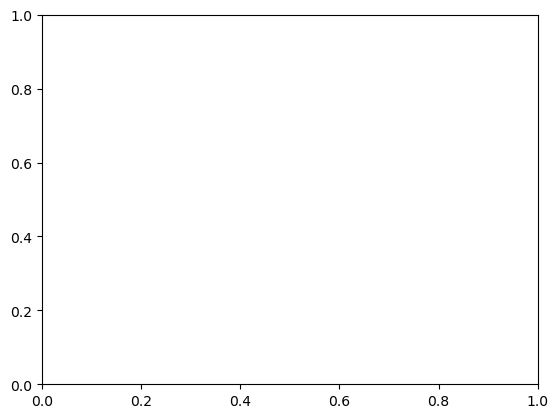

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('./'))


import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import h5py
#import seaborn as sns
import scipy.stats as stats
import datetime
import xarray as xr

import dsd_helper_functions as dfunc
import Config

import pickle

cfg = Config.Config('simulation_settings_vsense.yaml')
ycfg = cfg.v

import oa_stats as oa
import analysis_tools as AT


%matplotlib inline

%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 18})



In [2]:
def read_Rams(varname,filename):

    # arguments
    # varname: RAMS variable name, All CAPS
    # filename: pathname and filename of RAMS .h5 file
    # returns correctly reshaped data for 2D and 3D rams variables

    # get 3D dimension of RAMS file
    hf = h5py.File(filename,'r')

    # reshape RAMS 2D and 3D data of interest
    data = hf[varname]
    np_data = np.array(data)
    data_out=np_data
    
    return data_out 

In [3]:
nu='04'

In [4]:
ycfg['sims']['supercell_nu4']['diam_file']

'supercell-grant-hires-gnu04-g1-diam.h5'

In [15]:
def get_rams_datagroups(exper,rthresh=0.9,mu=0.0):
    alldsd = pickle.load(open('ramsworld3_dsd_mass.p','rb')) 
    mydir = "./"
    rfile =ycfg['sims'][exper]['rain_file']
    dfile =ycfg['sims'][exper]['diam_file']
    ddir = ycfg['sims'][exper]['dirnam']
    print(dfile)
    sim_cfg = ycfg['sims'][exper]
    nu = sim_cfg['nu']
    if nu != 'bin':
        nu = int(nu)
        mu = nu-1
    else:
        mu = mu
    tskip = 1#Add a value to skip times to make similar number of points to obs
    hskip = 1#Add a horizontal skip value to make similar number o points to obs
    print(f"working on {exper}",rfile)
    data = xr.open_dataset(f'{mydir}DOE.MICRO-simulations/{ddir}/{rfile}',engine='h5netcdf')
    print(f'DOE.MICRO-simulations/{ddir}/{dfile}')
    diam = xr.open_dataset(f'{mydir}DOE.MICRO-simulations/{ddir}/{dfile}')
    tms = []
    tt=0
    for t,r in enumerate(data['t_coords'][::tskip].values):
        tt=tt+tskip
        tms.append(tt)

    
    if mu != 0.0:
        
        filtered_rain_dsd_dict = dfunc.format_subsample_dsd_data_diam(data,diam, nu=mu, tskip=tskip, hskip=hskip,d3=False)
    else:
        filtered_rain_dsd_dict = dfunc.format_subsample_dsd_data_diam(data,diam, nu=mu, tskip=tskip, hskip=hskip,d3=False)

    blank = np.zeros((filtered_rain_dsd_dict['shp'][0],filtered_rain_dsd_dict['shp'][1],filtered_rain_dsd_dict['shp'][2]))

    ramr =np.ravel(np.zeros_like(blank))
    ramr[filtered_rain_dsd_dict['whgd']]=filtered_rain_dsd_dict['rrr']
    ramrr = np.reshape(ramr,filtered_rain_dsd_dict['shp'])

    ramn =np.ravel(np.zeros_like(blank))
    ramn[filtered_rain_dsd_dict['whgd']]=filtered_rain_dsd_dict['nww']
    ramnw = np.reshape(ramn,filtered_rain_dsd_dict['shp'])

    ramd =np.ravel(np.zeros_like(blank))
    ramd[filtered_rain_dsd_dict['whgd']]=filtered_rain_dsd_dict['d00']
    ramd0 = np.reshape(ramd,filtered_rain_dsd_dict['shp'])

    blankr=np.ravel(blank)
    blankb = blankr[filtered_rain_dsd_dict['whgd']]
    
    good_vars = ['nww', 'dmm', 'sigm', 'llwc', 'lrr', 'lnt']

    labels = [ycfg['vars'][_]['label'] for _ in good_vars]
    pc1sea, pc2sea = oa.get_eof_cast(filtered_rain_dsd_dict,alldsd,good_vars)

    ramsgroups1 = dfunc.get_groups(pc1sea,pc2sea,rthresh,rthresh,rthresh,rthresh)
    ramsvals1 = dfunc.make_groups(pc1sea,ramsgroups1)


    ramvals2dr =np.ravel(np.zeros_like(blank))*np.nan
    ramvals2dr[filtered_rain_dsd_dict['whgd']]=ramsvals1
    ramvals2d = np.reshape(ramvals2dr,filtered_rain_dsd_dict['shp'])
    


    return data, tms, ramvals2d, pc1sea,pc2sea,filtered_rain_dsd_dict,ramsgroups1


In [16]:
data, tms, ramvals2d, pc1sea,pc2sea,filtered_rain_dsd_dict,ramsgroups1= get_rams_datagroups('supercell_nu4')

supercell-grant-hires-gnu04-g1-diam.h5
working on supercell_nu4 supercell-grant-hires-gnu04-g1-rain.h5
DOE.MICRO-simulations/h5e.supercell.grant.hires.gnu04.300dx/supercell-grant-hires-gnu04-g1-diam.h5
npshape d0d (37, 750, 950)
d3 is  False
rr shape (37, 750, 950)
(37, 750, 950)
0.0


In [49]:
fig_dir = './FINAL/'

In [18]:
#Read in the Global Simulation mass-spectrum DSD data
alldsd = pickle.load(open("ramsworld3_dsd_mass.p",'rb'))

In [19]:
#THis is needed in order to preserve the 3D nature of the PCA and Groups.
blank = np.zeros((filtered_rain_dsd_dict['shp'][0],filtered_rain_dsd_dict['shp'][1],filtered_rain_dsd_dict['shp'][2]))

In [20]:
#Print the world averages
alldsd.averages

{'nww': 3.0016983,
 'dmm': 1.2266015,
 'sigm': 0.5483383,
 'llwc': -1.6802962,
 'lrr': -0.53433484,
 'lnt': 2.1683908}

In [21]:
import oa_stats as oa
good_vars = ['nww', 'dmm', 'sigm', 'llwc', 'lrr', 'lnt']
labels = [ycfg['vars'][_]['label'] for _ in good_vars]

#Here we send the data to the EOF but cast it into the PCs of the global simulations EOF
pc1sea, pc2sea = oa.get_eof_cast(filtered_rain_dsd_dict,alldsd,good_vars)




In [22]:
#Set the threshold for determining the groups
rthresh=0.9
seagroups = dfunc.get_groups(pc1sea,pc2sea,rthresh,rthresh,rthresh,rthresh)
seagroupvals = dfunc.make_groups(pc1sea,seagroups)



In [23]:
#Now setup the 3D PC values

pc1=np.zeros_like(blank)*np.nan
pc2 = np.zeros_like(blank)*np.nan

pc1r =np.ravel(pc1)
pc1r[filtered_rain_dsd_dict['whgd']]=pc1sea
pc1 = np.reshape(pc1r,filtered_rain_dsd_dict['shp'])

pc2r =np.ravel(pc2)
pc2r[filtered_rain_dsd_dict['whgd']]=pc1sea
pc2 = np.reshape(pc2r,filtered_rain_dsd_dict['shp'])

In [24]:

#Get the groups for the RAMS global simulations
ramsgroups1 = dfunc.get_groups(pc1sea,pc2sea,rthresh,rthresh,rthresh,rthresh)
ramsvals1 = dfunc.make_groups(pc1sea,ramsgroups1)




In [25]:
#Reformulate into the 3D

ramvals2dr =np.ravel(np.zeros_like(blank))*np.nan
ramvals2dr[filtered_rain_dsd_dict['whgd']]=ramsvals1
ramvals2d = np.reshape(ramvals2dr,filtered_rain_dsd_dict['shp'])




In [26]:
from matplotlib import colors
import matplotlib as mpl
import os
import argparse
import time
from matplotlib.colors import LogNorm

cols=['gray','r','g','gold','blue','orange','purple']
pcacol = colors.ListedColormap(cols)

def adjust_fhc_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(0.4, 7.4, 1.0))
    cb.ax.set_yticklabels(['Amb','Group1', 'Group2', 'Group3', 'Group4',
                           'Group5', 'Group6'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb




In [31]:
def get_vars(process_vars,nu,ramvals):
    whga = np.where(ramvals== 0)
    whg1 = np.where(ramvals == 1)
    whg2 = np.where(ramvals == 2)
    whg3 = np.where(ramvals == 3)
    whg4 = np.where(ramvals == 4)
    whg5 = np.where(ramvals == 5)
    whg6 = np.where(ramvals == 6)
    whg = np.where(ramvals >-1)
    groups = {'group1':whg1,
              'group2':whg2,
              'group3':whg3,
              'group4':whg4,
              'group5':whg5,
              'group6':whg6,
              'groupA':whga,
              'ALL':whg}
    
    typedat = {}
    mynewdir = './'
    rime_vars = ['vt_rain2prt','vt_rain2snt','vt_rain2agt','vt_rain2grt','vt_rain2hat']
    for rv in rime_vars:
        dat = read_Rams(rv,f'{mynewdir}supercell-grant-hires-gnu{nu}-300dx-g1-vt_rime.h5')
        gdat={}
        for g in groups.keys():
            whg = groups[g]
            datsum = (((np.sum(dat[whg]))/1000)/977)
            gdat[g]=datsum
        typedat[rv]=gdat
        
    super_vars = ['vt_cld2raint','vt_ice2raint']
    for rv in super_vars:
        dat = read_Rams(rv,f'{mynewdir}supercell-grant-hires-gnu{nu}-300dx-g1-extra1.h5')
        gdat={}
        for g in groups.keys():
            whg = groups[g]
            datsum = (((np.sum(dat[whg]))/1000)/977)
            gdat[g]=datsum
        typedat[rv]=gdat

    vap_vars = ['vt_vapraint']
    for rv in vap_vars:
        dat = read_Rams(rv,f'{mynewdir}supercell-grant-hires-gnu{nu}-300dx-g1-vt_vapor.h5')
        gdat={}
        for g in groups.keys():
            whg = groups[g]
            datsum = (((np.sum(dat[whg]))/1000)/977)
            gdat[g]=datsum
        typedat[rv]=gdat

    melt_vars = ['vt_meltsnowt','vt_meltaggrt','vt_meltgraut','vt_melthailt']
    for rv in melt_vars:
        print(rv)
        dat = read_Rams(rv,f'supercell-grant-hires-gnu{nu}-300dx-g1-vt_melt.h5')
        gdat={}
        for g in groups.keys():
            whg = groups[g]
            datsum = (((np.sum(dat[whg]))/1000)/977)
            gdat[g]=datsum
        typedat[rv]=gdat
    return typedat


In [32]:
process_vars = ['vt_rain2prt','vt_rain2snt','vt_rain2agt','vt_rain2grt','vt_rain2hat','vt_cld2raint','vt_vapraint'
               'vt_ice2raint','vt_meltsnowt','vt_meltaggrt','vt_meltgraut','vt_melthailt']



In [33]:
gnu1 = get_vars(process_vars,nu,ramvals2d)


vt_meltsnowt
vt_meltaggrt
vt_meltgraut
vt_melthailt


In [34]:
for r in gnu1.keys():
    print(r)

vt_rain2prt
vt_rain2snt
vt_rain2agt
vt_rain2grt
vt_rain2hat
vt_cld2raint
vt_ice2raint
vt_vapraint
vt_meltsnowt
vt_meltaggrt
vt_meltgraut
vt_melthailt


In [35]:
#sink
xlabes = ['ALL','group1','group2','group3','group4','group5','group6']

#sink
#sinklabs = ['vt_vapraint','vt_rain2prt','vt_rain2snt','vt_rain2agt','vt_rain2grt','vt_rain2hat']
vaprain = []
rime_rain_pr = []
rime_rain_sn = []
rime_rain_ag = []
rime_rain_gr = []
rime_rain_ha = []

#sourcelabs
cld2rain = []
meltsnowt= []
meltaggt = []
meltgraut = []
melthailt = []
ice2rain = []
vaprain = []


for x in xlabes:
#sinks
    vaprain.append(gnu1['vt_vapraint'][x]*-1)
    rime_rain_pr.append(gnu1['vt_rain2prt'][x])
    rime_rain_sn.append(gnu1['vt_rain2snt'][x])
    rime_rain_ag.append(gnu1['vt_rain2agt'][x])
    rime_rain_gr.append(gnu1['vt_rain2grt'][x])
    rime_rain_ha.append(gnu1['vt_rain2hat'][x])
    
    
    
#source
    cld2rain.append(gnu1['vt_cld2raint'][x])
    meltsnowt.append(gnu1['vt_meltsnowt'][x])
    meltaggt.append(gnu1['vt_meltaggrt'][x])
    meltgraut.append(gnu1['vt_meltgraut'][x])
    melthailt.append(gnu1['vt_melthailt'][x])
    ice2rain.append(gnu1['vt_ice2raint'][x])
    
    

    
    

In [36]:
#GAther all the sources and sinks for each group
#Sources: Cloud to Rain, Melt Snow, Melt Aggregates, Melt Graupel, Melt Hail, Ice to Rain
#Sinks: Rain to Vapor, Rain to Rime Pristine crystals, Rain to Rime Snow, Rain to Rime Aggregates, 
#       Rain to Rime Graupel, Rain to Rime Hail

all_source=(cld2rain[0],meltsnowt[0],meltaggt[0],
         meltgraut[0],melthailt[0],ice2rain[0])
all_sinks = ((vaprain[0]),rime_rain_pr[0],rime_rain_sn[0],
             rime_rain_ag[0],rime_rain_gr[0],rime_rain_ha[0])

all_total=np.sum(all_source)-np.sum(all_sinks)

f=1
g1_source=(cld2rain[f]+meltsnowt[f]+meltaggt[f]+
         meltgraut[f]+melthailt[f]+ice2rain[f])
g1_sink = ((vaprain[f])+rime_rain_pr[f]+rime_rain_sn[f]
            +rime_rain_ag[f]+rime_rain_gr[f]+rime_rain_ha[f])
g1_total=g1_source-g1_sink

f=2
g2_source=(cld2rain[f]+meltsnowt[f]+meltaggt[f]+
         meltgraut[f]+melthailt[f]+ice2rain[f])
g2_sink = ((vaprain[f])+rime_rain_pr[f]+rime_rain_sn[f]
          +rime_rain_ag[f]+rime_rain_gr[f]+rime_rain_ha[f])
g2_total=g2_source-g2_sink

f=3
g3_source=(cld2rain[f]+meltsnowt[f]+meltaggt[f]+
         meltgraut[f]+melthailt[f]+ice2rain[f])
g3_sink = ((vaprain[f])+rime_rain_pr[f]+rime_rain_sn[f]
            +rime_rain_ag[f]+rime_rain_gr[f]+rime_rain_ha[f])
g3_total=g3_source-g3_sink

f=4
g4_source=(cld2rain[f]+meltsnowt[f]+meltaggt[f]+
         meltgraut[f]+melthailt[f]+ice2rain[f])
g4_sink = ((vaprain[f])+rime_rain_pr[f]+rime_rain_sn[f]
            +rime_rain_ag[f]+rime_rain_gr[f]+rime_rain_ha[f])
g4_total=g4_source-g4_sink

f=5
g5_source=(cld2rain[f]+meltsnowt[f]+meltaggt[f]+
         meltgraut[f]+melthailt[f]+ice2rain[f])
g5_sink = ((vaprain[f])+rime_rain_pr[f]+rime_rain_sn[f]
            +rime_rain_ag[f]+rime_rain_gr[f]+rime_rain_ha[f])
g5_total=g5_source-g5_sink


f=6
g6_source=(cld2rain[f]+meltsnowt[f]+meltaggt[f]+
         meltgraut[f]+melthailt[f]+ice2rain[f])
g6_sink = ((vaprain[f])+rime_rain_pr[f]+rime_rain_sn[f]
            +rime_rain_ag[f]+rime_rain_gr[f]+rime_rain_ha[f])
g6_total=g6_source-g6_sink



group_source = np.array([np.sum(all_source),g1_source,g2_source,g3_source,g4_source,g5_source,g6_source])
group_sink = np.array([np.sum(all_sinks),g1_sink,g2_sink,g3_sink,g4_sink,g5_sink,g6_sink])




In [37]:
print(np.sum(all_source))
print(np.sum(all_sinks))
print(np.sum(all_source)-np.sum(all_sinks))

3.052361781047091
1.7172927808341862
1.3350690002129046


In [38]:
group_total = group_source-group_sink
# print(np.shape(group_total))
# np.insert(0,group_total,all_total)

In [39]:
print(group_total)
print(all_total)

[1.335069   0.90727006 0.00867295 0.0328077  0.04450999 0.2159021
 0.10140632]
1.3350690002129046


In [40]:
totals = [all_total,g1_total,g2_total,g3_total,g4_total,g5_total,g6_total]


In [41]:
print(nu)

04


In [42]:
#Group the data into Warm processes and Cold proceeses
#GAther all the sources and sinks for each group
#Warm Sources: Cloud to Rain, 
#Cold Sources: Melt Snow, Melt Aggregates, Melt Graupel, Melt Hail, Ice to Rain
#Warm Sinks: Rain to Vapor, 
#Cold Sinks: Rain to Rime Pristine crystals, Rain to Rime Snow, Rain to Rime Aggregates, 
#       Rain to Rime Graupel, Rain to Rime Hail

all_sourceW=(cld2rain[0])
all_sinksW = (vaprain[0])


all_sourceC=(meltsnowt[0],meltaggt[0],
         meltgraut[0],melthailt[0],ice2rain[0])
all_sinksC = (rime_rain_pr[0],rime_rain_sn[0],
             rime_rain_ag[0],rime_rain_gr[0],rime_rain_ha[0])


all_totalW=np.sum(all_sourceW)-np.sum(all_sinksW)
all_totalC=np.sum(all_sourceC)-np.sum(all_sinksC)

f=1
g1_sourceW=(cld2rain[f])
g1_sinkW = ((vaprain[f]))
g1_totalW=g1_sourceW-g1_sinkW

g1_sourceC=(meltsnowt[f]+meltaggt[f]+
         meltgraut[f]+melthailt[f]+ice2rain[f])
g1_sinkC = (rime_rain_pr[f]+rime_rain_sn[f]
            +rime_rain_ag[f]+rime_rain_gr[f]+rime_rain_ha[f])
g1_totalC=g1_sourceC-g1_sinkC



f=2
g2_sourceW=(cld2rain[f])
g2_sinkW = ((vaprain[f]))
g2_totalW=g2_sourceW-g2_sinkW

g2_sourceC=(meltsnowt[f]+meltaggt[f]+
       meltgraut[f]+melthailt[f]+ice2rain[f])
g2_sinkC = (rime_rain_pr[f]+rime_rain_sn[f]
            +rime_rain_ag[f]+rime_rain_gr[f]+rime_rain_ha[f])
g2_totalC=g2_sourceC-g2_sinkC


f=3
g3_sourceW=(cld2rain[f])
g3_sinkW = ((vaprain[f]))
g3_totalW=g3_sourceW-g3_sinkW

g3_sourceC=(meltsnowt[f]+meltaggt[f]+
         meltgraut[f]+melthailt[f]+ice2rain[f])
g3_sinkC = (rime_rain_pr[f]+rime_rain_sn[f]
            +rime_rain_ag[f]+rime_rain_gr[f]+rime_rain_ha[f])
g3_totalC=g3_sourceC-g3_sinkC


f=4
g4_sourceW=(cld2rain[f])
g4_sinkW = ((vaprain[f]))
g4_totalW=g4_sourceW-g4_sinkW

g4_sourceC=(meltsnowt[f]+meltaggt[f]+
       meltgraut[f]+melthailt[f]+ice2rain[f])
g4_sinkC = (rime_rain_pr[f]+rime_rain_sn[f]
            +rime_rain_ag[f]+rime_rain_gr[f]+rime_rain_ha[f])
g4_totalC=g4_sourceC-g4_sinkC

f=5
g5_sourceW=(cld2rain[f])
g5_sinkW = ((vaprain[f]))
g5_totalW=g5_sourceW-g5_sinkW

g5_sourceC=(meltsnowt[f]+meltaggt[f]+
         meltgraut[f]+melthailt[f]+ice2rain[f])
g5_sinkC = (rime_rain_pr[f]+rime_rain_sn[f]
            +rime_rain_ag[f]+rime_rain_gr[f]+rime_rain_ha[f])
g5_totalC=g5_sourceC-g5_sinkC

f=6
g6_sourceW=(cld2rain[f])
g6_sinkW = ((vaprain[f]))
g6_totalW=g6_sourceW-g6_sinkW

g6_sourceC=(meltsnowt[f]+meltaggt[f]+
         meltgraut[f]+melthailt[f]+ice2rain[f])
g6_sinkC = (rime_rain_pr[f]+rime_rain_sn[f]
            +rime_rain_ag[f]+rime_rain_gr[f]+rime_rain_ha[f])
g6_totalC=g6_sourceC-g6_sinkC





group_source = np.array([np.sum(all_source),g1_source,g2_source,g3_source,g4_source,g5_source,g6_source])
group_sink = np.array([np.sum(all_sinks),g1_sink,g2_sink,g3_sink,g4_sink,g5_sink,g6_sink])




In [43]:
#Total up the Sources and Sinks for each group

got1 = g1_sourceW+g1_sourceC+g1_sinkW+g1_sinkC
got2 = g2_sourceW+g2_sourceC+g2_sinkW+g2_sinkC
got3 = g3_sourceW+g3_sourceC+g3_sinkW+g3_sinkC
got4 = g4_sourceW+g4_sourceC+g4_sinkW+g4_sinkC
got5 = g5_sourceW+g5_sourceC+g5_sinkW+g5_sinkC
got6 = g6_sourceW+g6_sourceC+g6_sinkW+g6_sinkC

In [44]:
print(g1_sourceW,g1_sourceC,g1_sinkW,g1_sinkC)

0.6018180015353122 1.2859428101679198 0.3900521686284545 0.5904385815154811


In [45]:

all_tot = np.sum(all_sourceW)+np.sum(all_sourceC)+np.sum(all_sinksW)+np.sum(all_sinksC)
print(all_tot)
print(totals)

4.769654561881277
[1.3350690002129046, 0.9072700615592962, 0.00867294954667926, 0.03280769764364315, 0.04450999443753105, 0.21590209632178547, 0.10140631816770303]


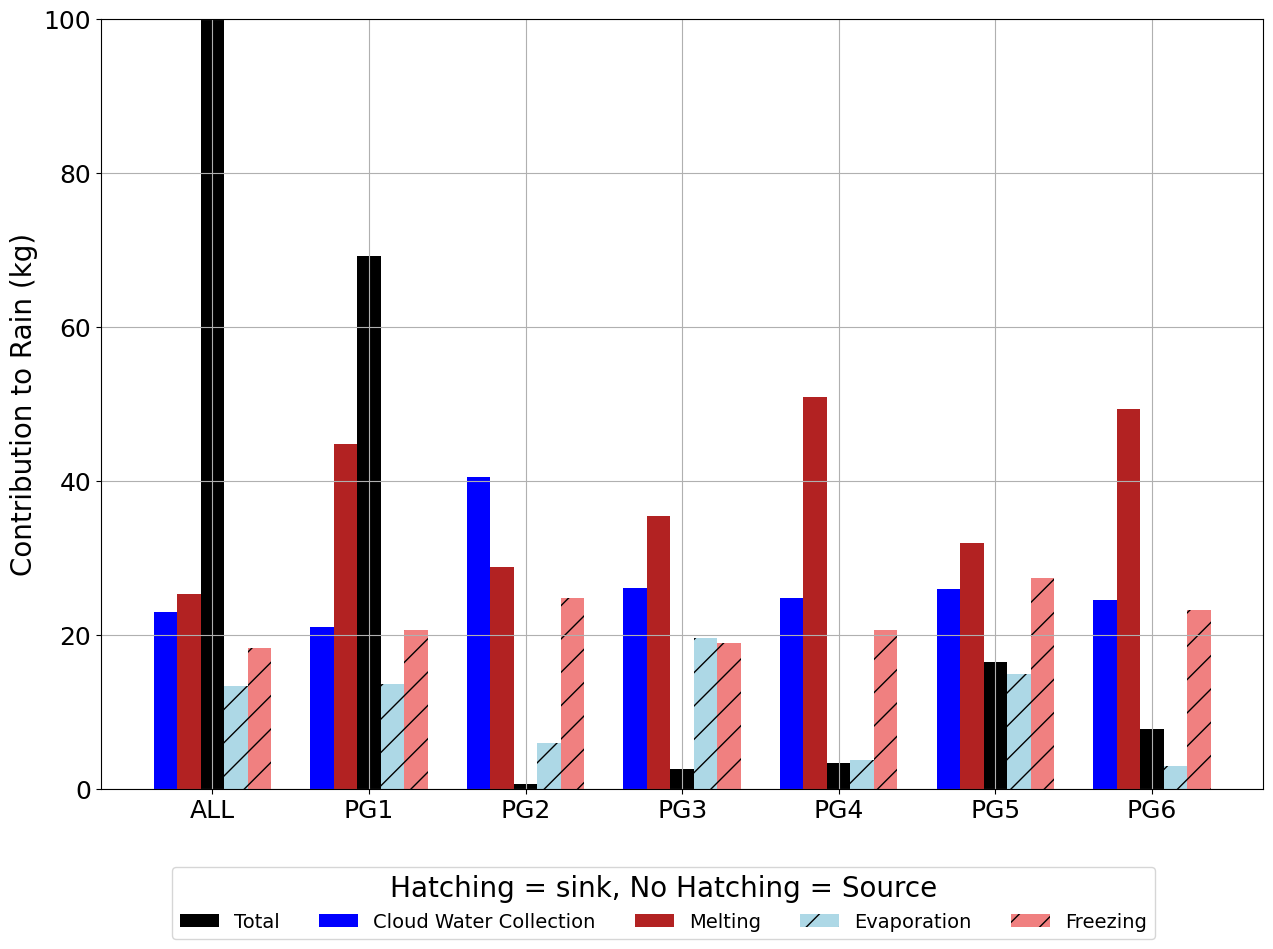

In [50]:
x=np.arange(0,7,1)
width=0.15


fig, ax = plt.subplots(1,1,figsize=(15,10))

#Total
ax.bar(0-2*width,all_sourceW/all_tot*100.,width=width,color='blue')
ax.bar(0-width,all_sourceC/all_tot*100.,width=width,color='Firebrick')
plt.bar(x,totals/np.sum(totals[1:])*100,width=width,label='Total', color='black')
ax.bar(0+width,all_sinksW/all_tot*100.,width=width,color='lightblue',hatch='/')
ax.bar(0+2*width,all_sinksC/all_tot*100.,width=width,color='lightcoral',hatch='/')
f =1
#sources
ax.bar(f-2*width, g1_sourceW/got1*100, width=width, label='Cloud Water Collection', color='blue')

ax.bar(f-width,g1_sourceC/got1*100, width=width,label='Melting', color ='Firebrick')

ax.bar(f+width,g1_sinkW/got1*100, width=width, label='Evaporation', color='lightblue', hatch='/')

ax.bar(f+2*width,g1_sinkC/got1*100, width=width, label='Freezing', color='lightcoral', hatch='/')


f =2
#sources
ax.bar(f-2*width, g2_sourceW/got2*100, width=width, color='blue')

ax.bar(f-width,g2_sourceC/got2*100, width=width,color ='Firebrick')

ax.bar(f+width,g2_sinkW/got2*100, width=width,  color='lightblue', hatch='/')

ax.bar(f+2*width,g2_sinkC/got2*100, width=width, color='lightcoral', hatch='/')


f =3
#sources
ax.bar(f-2*width, g3_sourceW/got3*100, width=width, color='blue')

ax.bar(f-width,g3_sourceC/got3*100, width=width,color ='Firebrick')

ax.bar(f+width,g3_sinkW/got3*100, width=width,  color='lightblue', hatch='/')

ax.bar(f+2*width,g3_sinkC/got3*100, width=width, color='lightcoral', hatch='/')


f =4
#sources
ax.bar(f-2*width, g4_sourceW/got4*100, width=width, color='blue')

ax.bar(f-width,g4_sourceC/got4*100, width=width,color ='Firebrick')

ax.bar(f+width,g4_sinkW/got4*100, width=width,  color='lightblue', hatch='/')

ax.bar(f+2*width,g4_sinkC/got4*100, width=width, color='lightcoral', hatch='/')


f =5
#sources
ax.bar(f-2*width, g5_sourceW/got5*100, width=width, color='blue')

ax.bar(f-width,g5_sourceC/got5*100, width=width,color ='Firebrick')

ax.bar(f+width,g5_sinkW/got5*100, width=width,  color='lightblue', hatch='/')

ax.bar(f+2*width,g5_sinkC/got5*100, width=width, color='lightcoral', hatch='/')


f =6
#sources
ax.bar(f-2*width, g6_sourceW/got6*100, width=width, color='blue')

ax.bar(f-width,g6_sourceC/got6*100, width=width,color ='Firebrick')

ax.bar(f+width,g6_sinkW/got6*100, width=width,  color='lightblue', hatch='/')

ax.bar(f+2*width,g6_sinkC/got6*100, width=width, color='lightcoral', hatch='/')




ax.set_xticks(x)
ax.set_xticklabels(['ALL','PG1', 'PG2', 'PG3', 'PG4',
                       'PG5', 'PG6'])
text="Hatching = sink, No Hatching = Source"
#ax2.legend(fontsize=30, frameon=True, fancybox=True, ncol=4, bbox_to_anchor=(0.5,-.2), 
#          loc='lower center', title=text, title_fontsize=40)


fig.legend(fontsize=14, frameon=True, fancybox=True, ncol=5, bbox_to_anchor=(0.5,-.05), 
          loc='lower center', title=text, title_fontsize=20)

ax.set_ylabel('Contribution to Rain (kg)', fontsize=20)
ax.grid()
ax.set_ylim(0,100)

mu = int(nu)-1
#plt.suptitle(f'Rain budget for Supercell $\\mu${mu} By group ',fontsize=20)
plt.savefig(f'{fig_dir}RainBudget_supercell{nu}_eachgroup_{rthresh}_simple.png',dpi=400,bbox_inches='tight',facecolor='white')